In [1]:
import os
from collections import Counter
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_video import VideoFrameGenerator

In [71]:
def images_to_videos(folder_names, classes):
    if not os.path.exists('videos'):
        os.makedirs('videos')
    for folder in folder_names:
        if not os.path.exists('videos/' + folder):
            os.makedirs('videos/' + folder)
        for class_name in classes:
            if not os.path.exists('videos/' + folder + '/' + class_name):
                os.makedirs('videos/' + folder + '/' + class_name)
            image_folder = 'images/' + folder + '/' + class_name
            files_list = os.listdir(image_folder)
            filenames = []
            for files in files_list:
                filenames.append(files[0:4])
            
            # Keeping videos with at least 5 frames
            files_dict = {k: v for k, v in Counter(filenames).items() if v > 4}
            for file, count in files_dict.items():
                images = [img for img in os.listdir(image_folder) if img[0:4] == file]
                frame = cv2.imread(os.path.join(image_folder, images[0]))
                height, width, layers = frame.shape
                
                video_name = 'videos/' + folder + '/' + class_name + '/' + file + '_video.avi'
                video = cv2.VideoWriter(video_name, 0, 1, (width, height))
                
                for image in images:
                    video.write(cv2.imread(os.path.join(image_folder, image)))
                cv2.destroyAllWindows()
                video.release()
    return None

images_to_videos(folder_names, classes)

In [3]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = "videos/training"
TEST_DATA_DIR = "videos/testing"
EVAL_DIR = "final_evaluation"
BATCH_SIZE = 8
EPOCHS=20
FRAMES = 5
CHANNELS = 3

folder_names = ['training', 'testing']
classes = ['flip', 'notflip']

glob_train_pattern = TRAINING_DATA_DIR + '/{classname}/*.avi'
glob_test_pattern = TEST_DATA_DIR + '/{classname}/*.avi'

In [4]:
print("Total Number of training data:", sum(len(files) for f, s, files in os.walk(TRAINING_DATA_DIR)))
print("Total Number of testing data:", sum(len(files) for f, s, files in os.walk(TEST_DATA_DIR)))

Total Number of training data: 117
Total number of training videos for class flip: 65
Total number of training videos for class notflip: 52


Total Number of testing data: 65
Total number of training videos for class flip: 30
Total number of training videos for class notflip: 35


In [5]:
data_augmentation = ImageDataGenerator(zoom_range=.1,
                                       horizontal_flip=True,
                                       rotation_range=8,
                                       width_shift_range=.2,
                                       height_shift_range=.2,)

training_set = VideoFrameGenerator(classes=classes,
                                   rescale=1./255,
                                   glob_pattern=glob_train_pattern,
                                   nb_frames=FRAMES,
                                   shuffle=True,
                                   batch_size=BATCH_SIZE,
                                   target_shape=IMAGE_SHAPE,
                                   nb_channel=CHANNELS,
                                   transformation=data_augmentation,
                                   use_frame_cache=False,)

test_set = VideoFrameGenerator(classes=classes,
                               rescale=1./255,
                               glob_pattern=glob_test_pattern,
                               nb_frames=FRAMES,
                               shuffle=True,
                               batch_size=BATCH_SIZE,
                               target_shape=IMAGE_SHAPE,
                               nb_channel=CHANNELS,
                               use_frame_cache=False,)

Total data: 2 classes for 117 files for train
Total data: 2 classes for 65 files for train


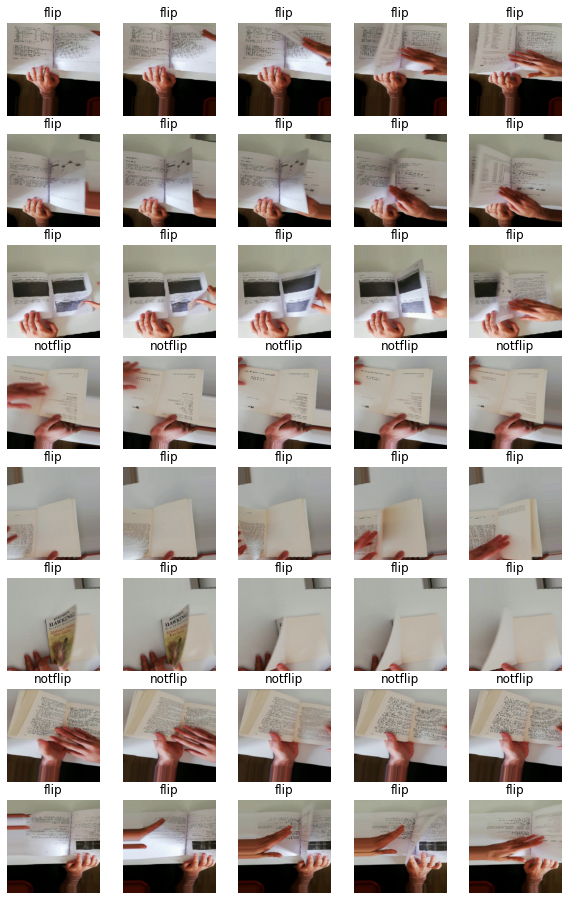

In [6]:
# Change this

from keras_video.utils import show_sample
show_sample(training_set, row_height=2, row_width=10)

In [7]:
momentum = .9
classifier_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    #tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    #tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    #tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    #tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.GlobalMaxPool2D()])

def my_model(shape=(5, 224, 224, 3)):
    model = tf.keras.Sequential([tf.keras.layers.TimeDistributed(classifier_model, input_shape=shape),
                                tf.keras.layers.LSTM(128),
                                tf.keras.layers.Dense(64, activation='relu'),
                                #tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(2, activation='sigmoid')])
    return model
    


In [8]:
SHAPE = (FRAMES, ) + IMAGE_SHAPE + (CHANNELS,)
model = my_model(shape=SHAPE)
callback = [tf.keras.callbacks.ReduceLROnPlateau(verbose=1)]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics=["accuracy"])


model_history = model.fit(training_set,
                          epochs=50,
                          validation_data=test_set,
                          callbacks=callback,)

Epoch 1/50
14/14 [==============================] - 128s 9s/step - loss: 0.6966 - accuracy: 0.4554 - val_loss: 0.6921 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 15s 1s/step - loss: 0.6923 - accuracy: 0.5446 - val_loss: 0.6943 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 10s 739ms/step - loss: 0.6913 - accuracy: 0.5536 - val_loss: 0.6959 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 10s 734ms/step - loss: 0.6883 - accuracy: 0.5625 - val_loss: 0.7143 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 10s 735ms/step - loss: 0.6917 - accuracy: 0.5446 - val_loss: 0.7012 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 11s 766ms/step - loss: 0.6898 - accuracy: 0.5446 - val_loss: 0.6996 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 7/50
14/14 [==============================] - 11s 761ms/step - 

In [15]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 5, 64)            24528     
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 131,730
Trainable params: 131,730
Non-trainable params: 0
_________________________________________________________________


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense

def build_convnet(shape=(150, 270, 3)):
    momentum = .9
    model = tf.keras.Sequential()
    model.add(Conv2D(8, (3,3), input_shape=shape, padding='same', activation='relu'))
    model.add(MaxPool2D())
    
    model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPool2D())
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(GlobalMaxPool2D())
    return model

def action_model(shape=(5, 150, 270, 3)):
    convnet = build_convnet(shape[1:])
    model = tf.keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape=shape))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    return model

INSHAPE=(FRAMES, ) + IMAGE_SHAPE + (CHANNELS,)
model = action_model(INSHAPE)
optimizer = tf.keras.optimizers.Adam(1e-5)
model.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['accuracy']
)

EPOCHS=40
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(verbose=1)]
history = model.fit(
    training_set,
    validation_data=test_set,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks)

Epoch 1/40
14/14 [==============================] - 19s 1s/step - loss: 0.6952 - accuracy: 0.4375 - val_loss: 0.6925 - val_accuracy: 0.5469 - lr: 1.0000e-05
Epoch 2/40
14/14 [==============================] - 16s 1s/step - loss: 0.6944 - accuracy: 0.4286 - val_loss: 0.6931 - val_accuracy: 0.5312 - lr: 1.0000e-05
Epoch 3/40
14/14 [==============================] - 16s 1s/step - loss: 0.6935 - accuracy: 0.4286 - val_loss: 0.6932 - val_accuracy: 0.5781 - lr: 1.0000e-05
Epoch 4/40
14/14 [==============================] - 16s 1s/step - loss: 0.6930 - accuracy: 0.5536 - val_loss: 0.6936 - val_accuracy: 0.4688 - lr: 1.0000e-05
Epoch 5/40
14/14 [==============================] - 16s 1s/step - loss: 0.6926 - accuracy: 0.5625 - val_loss: 0.6938 - val_accuracy: 0.4688 - lr: 1.0000e-05
Epoch 6/40
14/14 [==============================] - 16s 1s/step - loss: 0.6922 - accuracy: 0.5536 - val_loss: 0.6940 - val_accuracy: 0.4688 - lr: 1.0000e-05
Epoch 7/40
14/14 [==============================] - 16s 1s

KeyboardInterrupt: 